# Preamble and Open Data

In [31]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Useful links


https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction#%F0%9F%94%8CASHRAE--Start-Here:-A-GENTLE-Introduction

https://www.kaggle.com/c/ashrae-energy-prediction/data

1449 total different buildings examined!

In [2]:
df_t = pd.read_pickle(r'C:\Users\lukep\Documents\big_data\ASHRAE\train_r.pkl')
df_bs = pd.read_pickle(r'C:\Users\lukep\Documents\big_data\ASHRAE\building_metadata_r.pkl')
df_wt = pd.read_pickle(r'C:\Users\lukep\Documents\big_data\ASHRAE\weather_train_r.pkl')

Building data

In [3]:
df_bs.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


Training data

In [4]:
df_t.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


Weather data

In [5]:
df_wt.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


# Preliminary Examination of Data

## Building Spec Data

Note that there are 15 different sites being examined. Here is the distribution of the 1449 buildings across the various sites. From observing this plot we see that stratified sampling should be used when using any ML techniques.

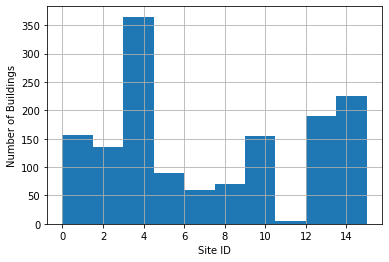

In [6]:
df_bs['site_id'].hist()
plt.xlabel('Site ID')
plt.ylabel('Number of Buildings')
plt.show()

Look at the various buildings examined. First get how many missing entries there are.

In [7]:
type_missing = df_bs['primary_use'].isnull().sum()
feet_missing = df_bs['square_feet'].isnull().sum()
floor_missing = df_bs['floor_count'].isnull().sum()
year_missing = df_bs['year_built'].isnull().sum()

Plot.

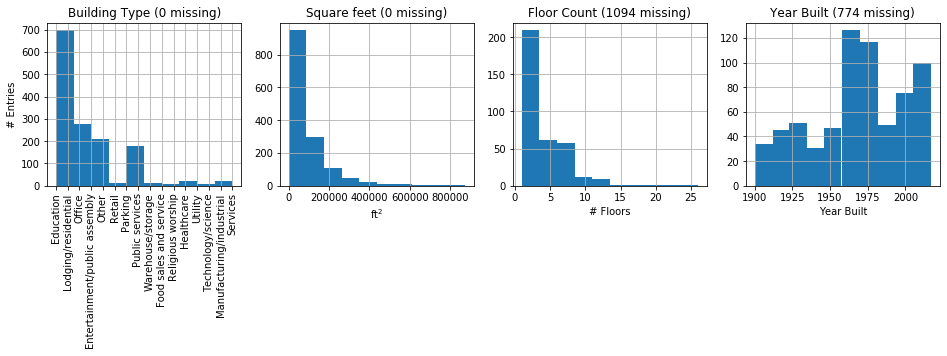

In [8]:
fig, ax = plt.subplots(1,4,figsize=(16,3))
df_bs['primary_use'].hist(xrot=90, ax=ax[0])
df_bs['square_feet'].hist(ax=ax[1])
df_bs['floor_count'].hist(ax=ax[2])
df_bs['year_built'].hist(ax=ax[3])

ax[0].set_title('Building Type ({} missing)'.format(type_missing))
ax[1].set_title('Square feet ({} missing)'.format(feet_missing))
ax[2].set_title('Floor Count ({} missing)'.format(floor_missing))
ax[3].set_title('Year Built ({} missing)'.format(year_missing))

ax[0].set_ylabel('# Entries')
ax[1].set_xlabel('ft$^2$')
ax[2].set_xlabel('# Floors')
ax[3].set_xlabel('Year Built')

plt.show()

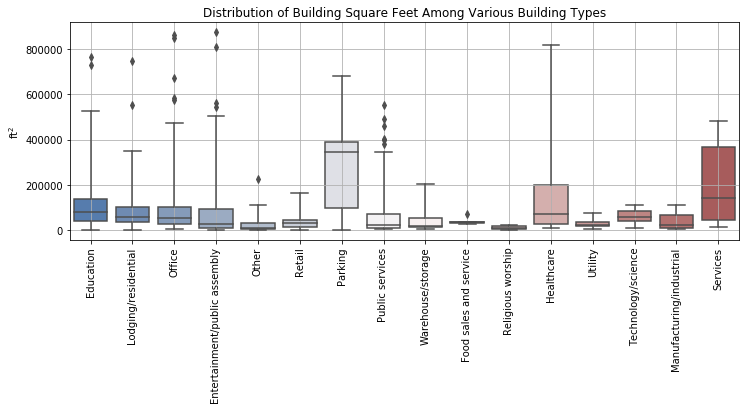

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.boxplot(x='primary_use', y="square_feet", whis=5, data=df_bs, palette="vlag", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_xlabel('')
ax.set_ylabel('ft$^2$')
ax.set_title('Distribution of Building Square Feet Among Various Building Types')
ax.grid()
plt.show()

This suggests that there are some very large buildings and that these might be outliers (these points exist beyond the $5 \times $IQR point).

## Temperature Data

Air Temperatures

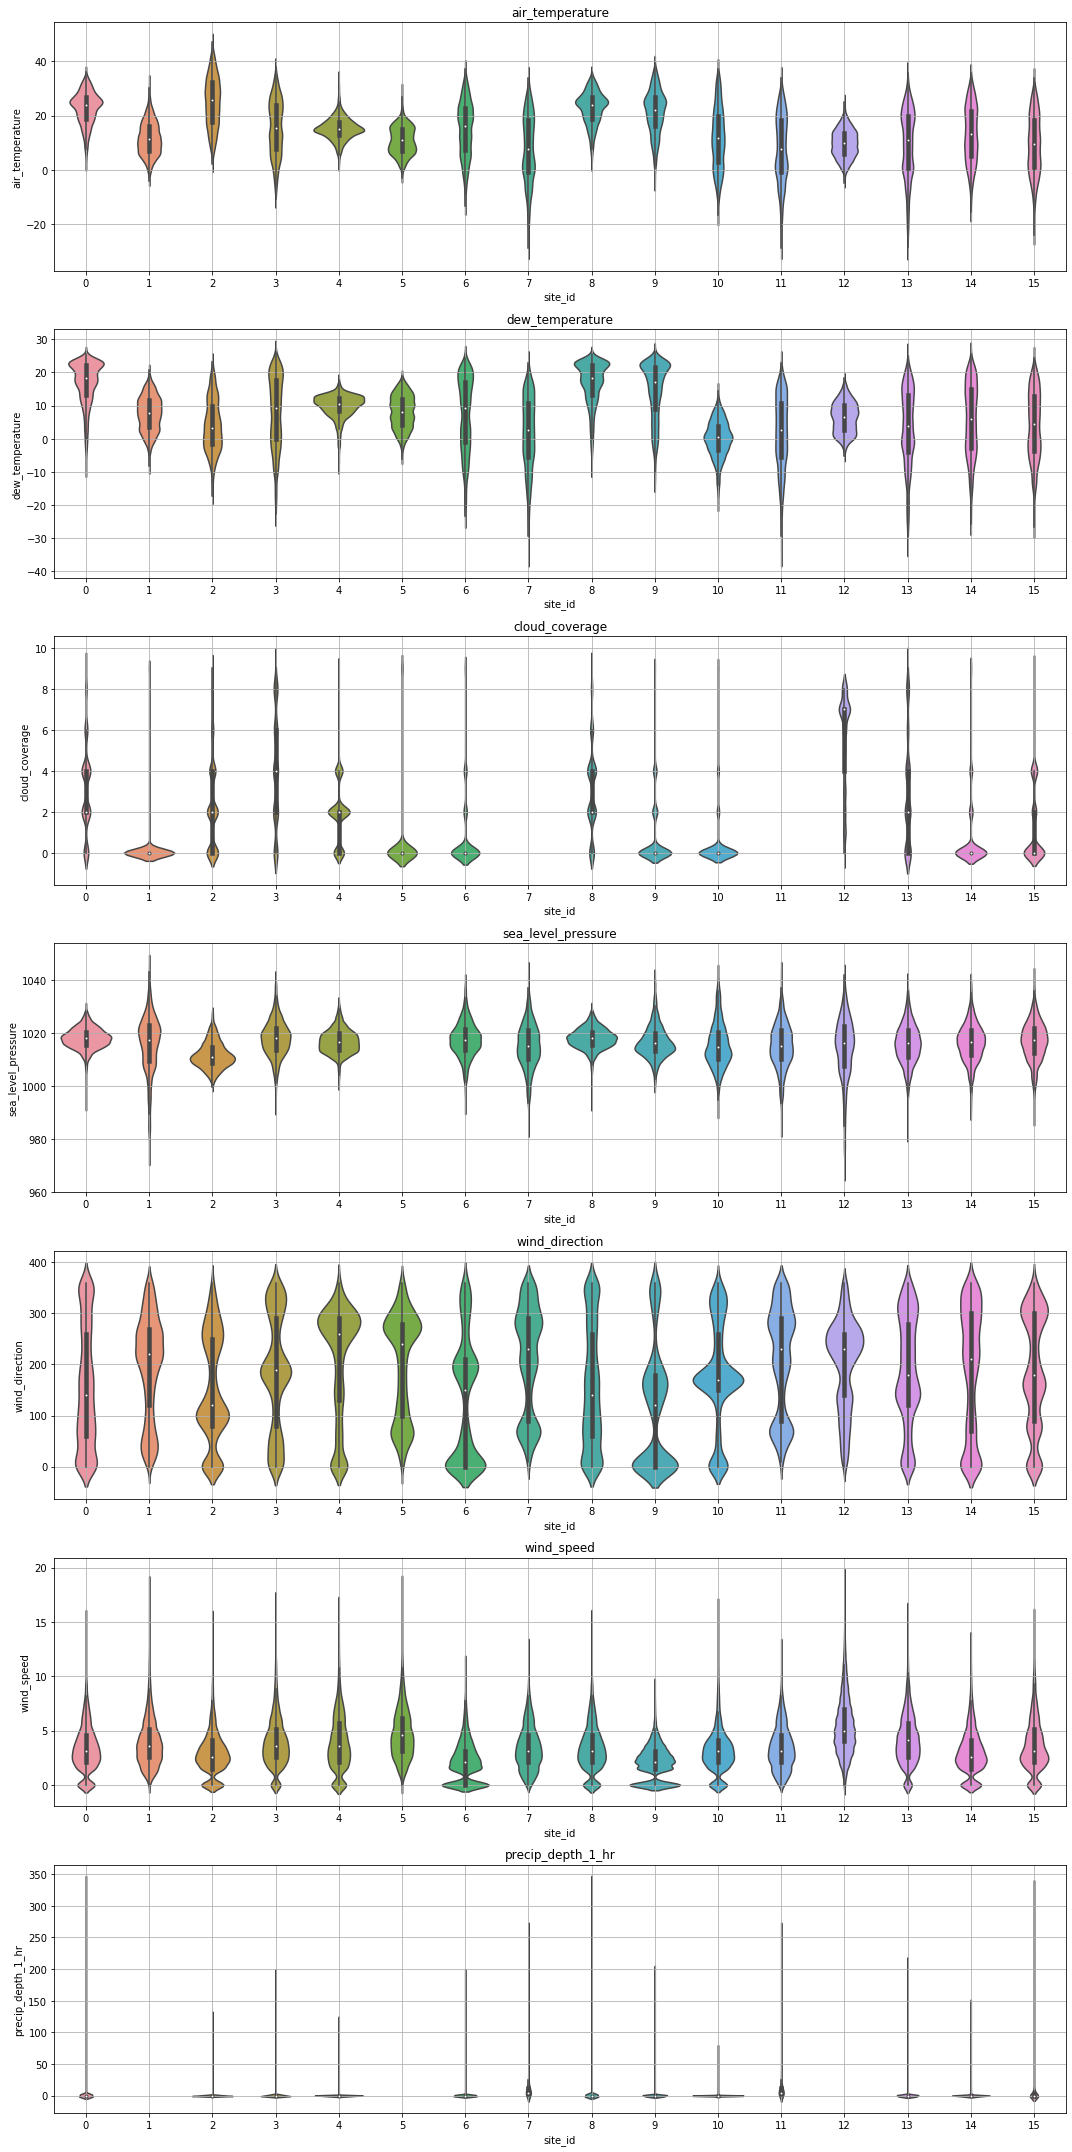

In [43]:
fig, ax = plt.subplots(7,1,figsize=(15,30))
attribs = ['air_temperature', 'dew_temperature',
           'cloud_coverage', 'sea_level_pressure',
           'wind_direction', 'wind_speed', 'precip_depth_1_hr']
for i, attrib in enumerate(attribs):
    sns.violinplot(x="site_id",
                   y=attrib,
                   data=df_wt.astype({attrib: 'float64'}),
                   ax=ax[i])
    ax[i].set_title(attrib)
    ax[i].grid()

fig.tight_layout()
plt.show()

Plot correlations of these variables.

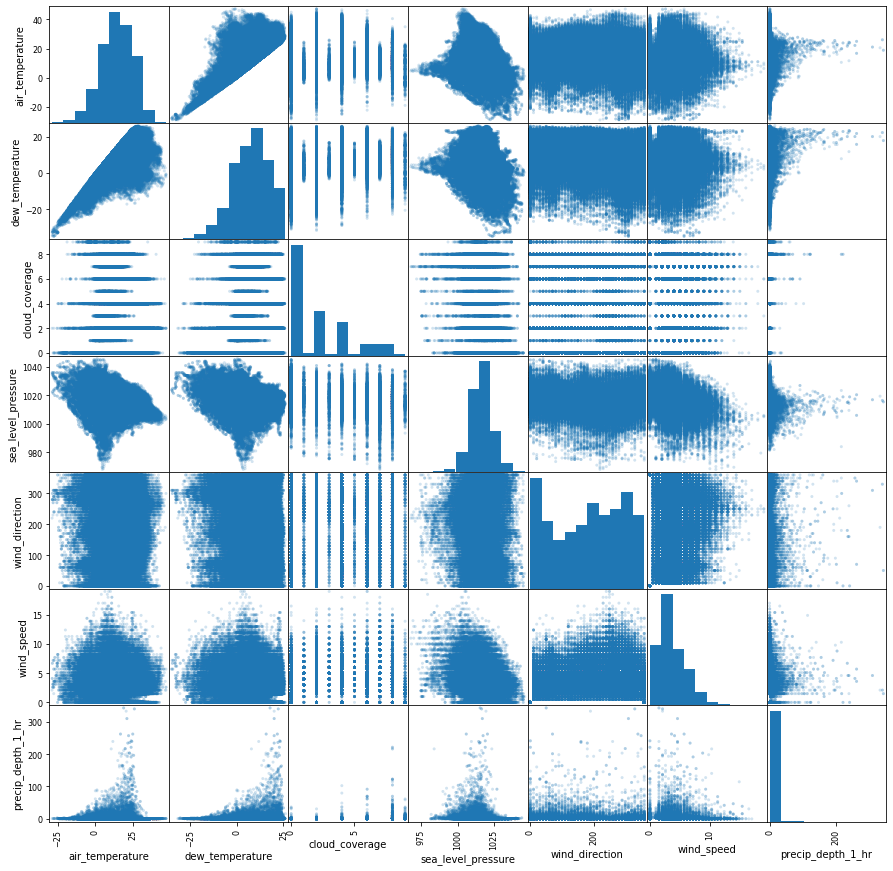

In [44]:
scatter_matrix(df_wt[attribs], alpha = 0.2, figsize = (15, 15)); # plotting scatter plot matrix

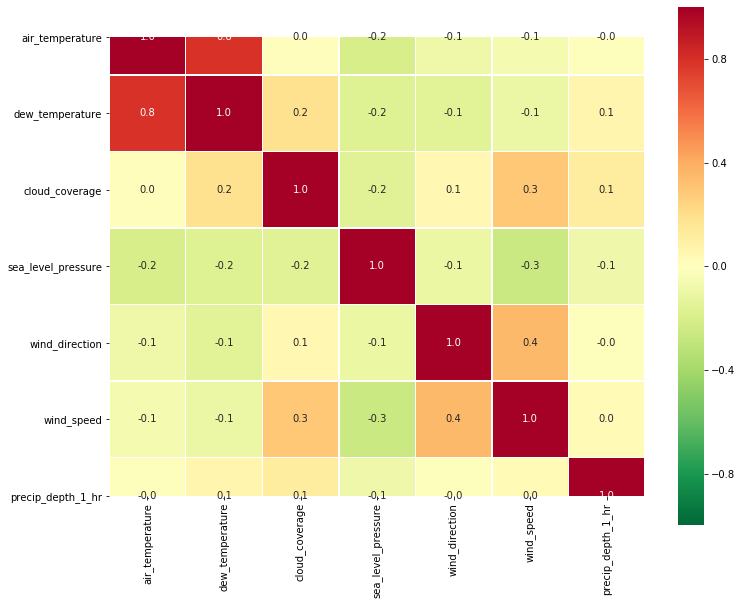

In [45]:
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df_wt[attribs].corr(), annot=True, square=True, linewidths=.5, fmt= '.1f',ax=ax, vmin=-1, vmax=1, cmap='RdYlGn_r')
plt.subplots_adjust(bottom=0.28)
plt.show()

Air temperature and dew point temperature are vairly correlated, but the rest aren't. This suggests that most of these RVs are independent, which is good for the ML algorithm.

## Meter Reading Data

First lets look at the proportion of buildings that have readings on the various meters. Recall
* 0: electricity 
* 1: chilledwater 
* 2: steam
* 3: hotwater

In [126]:
df_ = df_t.groupby(['building_id', 'meter']).mean()

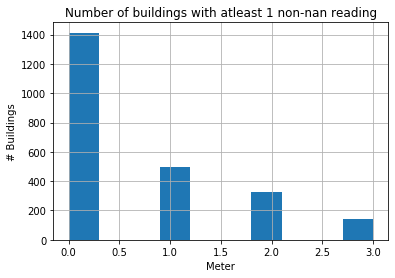

In [134]:
df_.reset_index()['meter'].hist()
plt.xlabel('Meter')
plt.ylabel('# Buildings')
plt.title('Number of buildings with atleast 1 non-nan reading')
plt.show()

Perhaps the best thing would be to do a seperate machine learning model for each meter.

### Electricity

In [138]:
building_1 = df_t[df_t['building_id']==0][df_t['meter']==0]

C:\Users\lukep\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Meter Value')

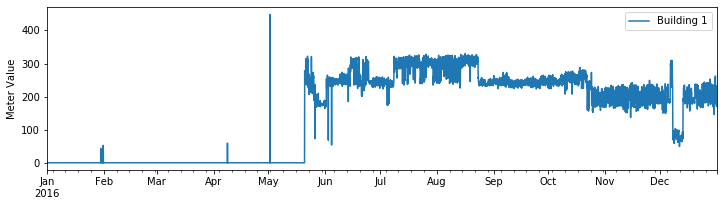

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(12,3))
building_1.plot(x='timestamp', y='meter_reading', label='Building 1', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Meter Value')

Even though this contains some non-zeros, we expect that the data earlier on is corrupted. These data points can be removed using

https://www.kaggle.com/purist1024/ashrae-simple-data-cleanup-lb-1-08-no-leaks